In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from survae import SurVAE, DEVICE
from survae.data import MNIST_784
from survae.layer import *
from survae.calibrate import *

import json

In [2]:
SAVE_PATH = "./saves/sv_maxpool overnight 6"

In [3]:
mnist_dataset = MNIST_784()

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:100: UserWarning: A network error occurred while downloading https://openml.org/api/v1/json/data/list/data_name/mnist_784/limit/2/data_version/1. Retrying...
  warn(


In [4]:
sv_maxpool = SurVAE(
    [DequantizationLayer()] +
    [
        [BijectiveLayer(784, [200, 200]), OrthonormalLayer(784)] # 784 = 28^2
        for _ in range(5)
    ] +
    [MaxPoolingLayer(784, 2, learn_distribution_parameter=True)] + 
    [
        [BijectiveLayer(196, [200, 200]), OrthonormalLayer(196)] # 196 = 14^2
        for _ in range(5)
    ] +
    [MaxPoolingLayer(196, 2, learn_distribution_parameter=True)] +
    [
        [BijectiveLayer(49, [200, 200]), OrthonormalLayer(49)] # 49 = 7^2
        for _ in range(5)
    ] +
    [MaxPoolingLayerWithHop(49, 3, 2, learn_distribution_parameter=True)] +
    [
        [BijectiveLayer(9, [200, 200]), OrthonormalLayer(9)] # 9 = 3^2
        for _ in range(5)
    ],
    name = "SV_MAXPOOL",
    condition_size = 10,
)

In [5]:
# load model
sv_maxpool.load_state_dict(torch.load("saves/sv_maxpool overnight 5/epoch_50000.pt"))

<All keys matched successfully>

In [6]:
train_log = sv_maxpool.train(
    dataset    = mnist_dataset,
    batch_size = 200,
    test_size  = 1_000,
    epochs     = 240_000,
    lr         = 1e-4,
    log_period = 2_000,
    show_tqdm  = True,
    lr_decay_params = None,
    save_path = SAVE_PATH,
    record_std=True,
)

100%|██████████| 240000/240000 [7:26:32<00:00,  8.96it/s]  


### Plot loss

In [7]:
times = list(train_log.keys())
loss_train = [m.training_loss for m in train_log.values()]
loss_test = [m.testing_loss for m in train_log.values()]
sigmas = [m.sigma for m in train_log.values()]

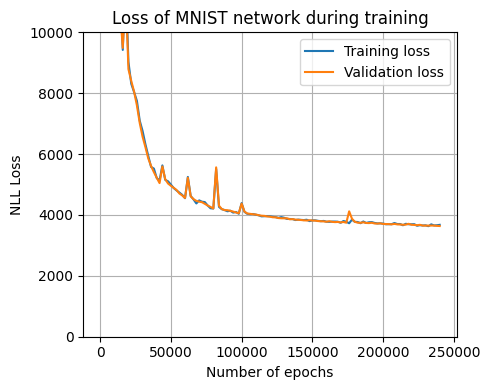

In [11]:
plt.figure(figsize=(5, 4))

plt.plot(times, loss_train, label='Training loss')
plt.plot(times, loss_test, label='Validation loss')

plt.title('Loss of MNIST network during training')
plt.xlabel('Number of epochs')
plt.ylabel('NLL Loss')

plt.grid()
plt.ylim(0, 1e4)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# check that sigma parameters are actually being learned
for _layer in sv_maxpool.layers:
    if isinstance(_layer, (MaxPoolingLayer, MaxPoolingLayerWithHop)):
        print(f"{(_s := _layer.sigma).item():.4f}")
        # print(f"   {_s.grad.item():.4f}")

23.7374
11.6524
14.1129


In [13]:
# save loss values & sigma
with open(SAVE_PATH + "/output/loss_test.txt", "w") as f:
    json.dump(loss_test, f, indent=0)

with open(SAVE_PATH + "/output/loss_train.txt", "w") as f:
    json.dump(loss_train, f, indent=0)

with open(SAVE_PATH + "/output/sigmas.txt", "w") as f:
    json.dump(sigmas, f, indent=0)

In [ ]:
# load loss values
with open(SAVE_PATH + "/output/loss_test.txt", "r") as f:
    _loss_test = json.load(f)

with open( SAVE_PATH + "/output/loss_train.txt", "r") as f:
    _loss_train = json.load(f)

## Calibration

In [14]:
X, y = mnist_dataset.sample(10_000, labels=True)
y = mnist_dataset.label_to_one_hot(y, 10)

with torch.no_grad():
    Z = sv_maxpool(X, y).cpu()

In [17]:
# calculate standard deviation
print(f"Standard deviation of code distribution is measured to be {Z.std().item():.4f}")

Standard deviation of code distribution is measured to be 1.0941


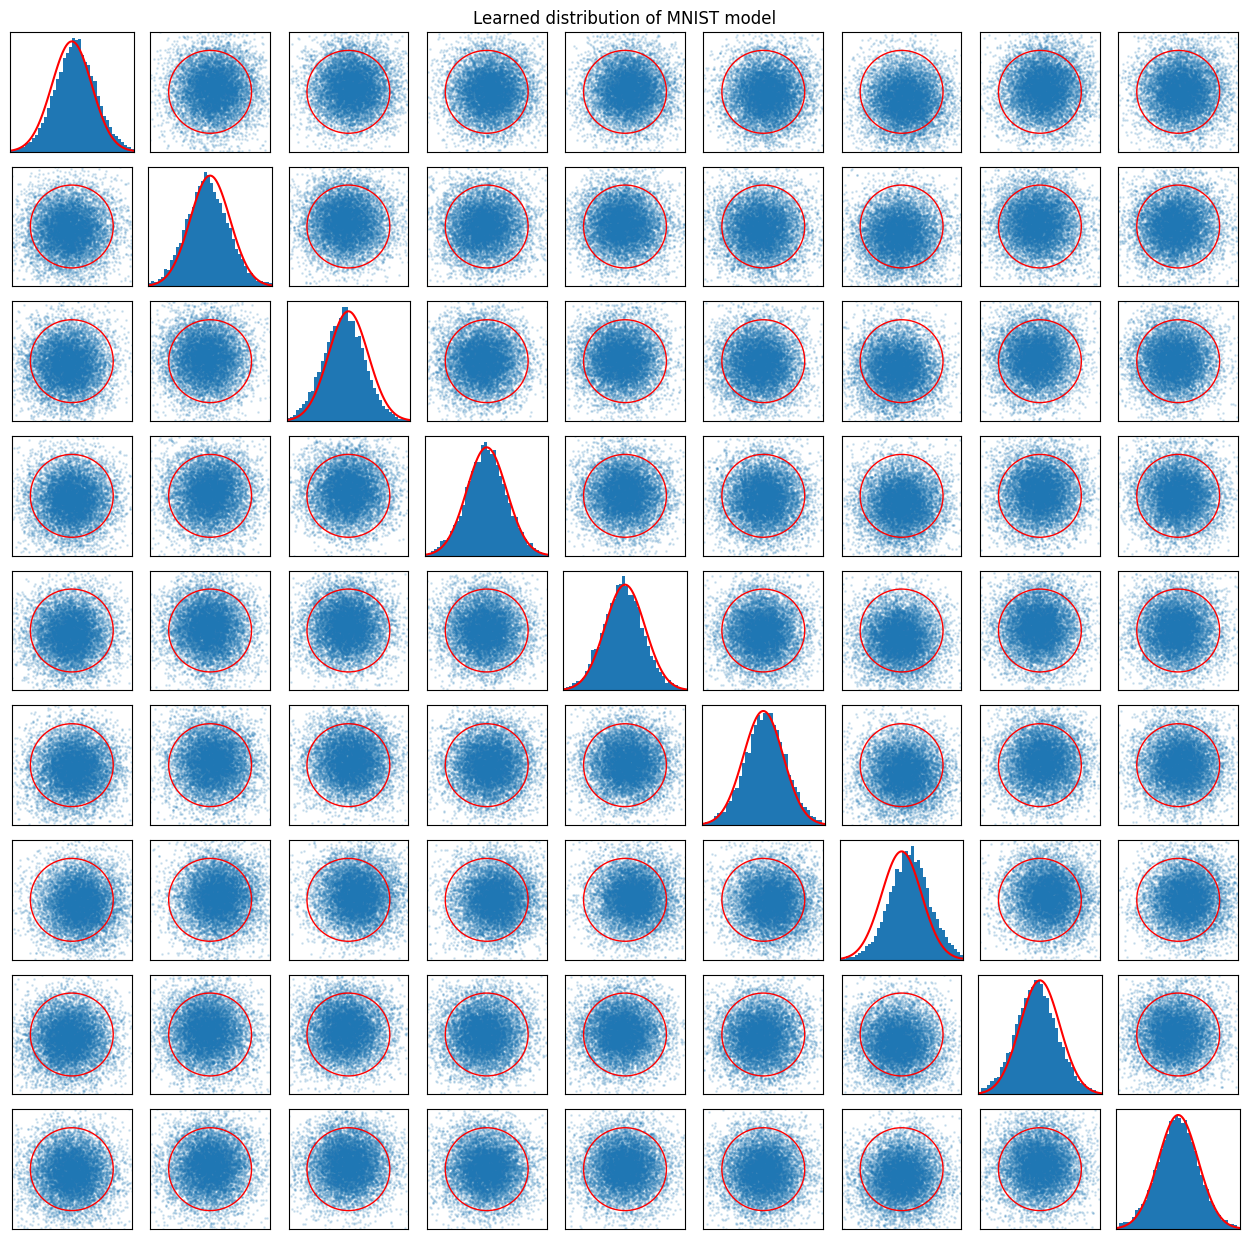

In [19]:
plot_learned_distribution(Z, f"Learned distribution of MNIST model", plotsize=1.4, axis_scale=3.1)

## Sampling

In [20]:
ncols = 10
nrows = 4
plotsize = 1.5

In [21]:
# sample 1's
# _y = torch.tensor([1]).expand(ncols * nrows)

# sample every kind of number several times
_y = torch.arange(10).repeat(nrows)
print(_y)

y = mnist_dataset.label_to_one_hot(_y, 10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
        4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


In [22]:
# manually specify the standard deviation for the samples
with torch.no_grad():
    X_hat = sv_maxpool.sample(len(y), y).view(nrows, ncols, 28, 28).cpu()

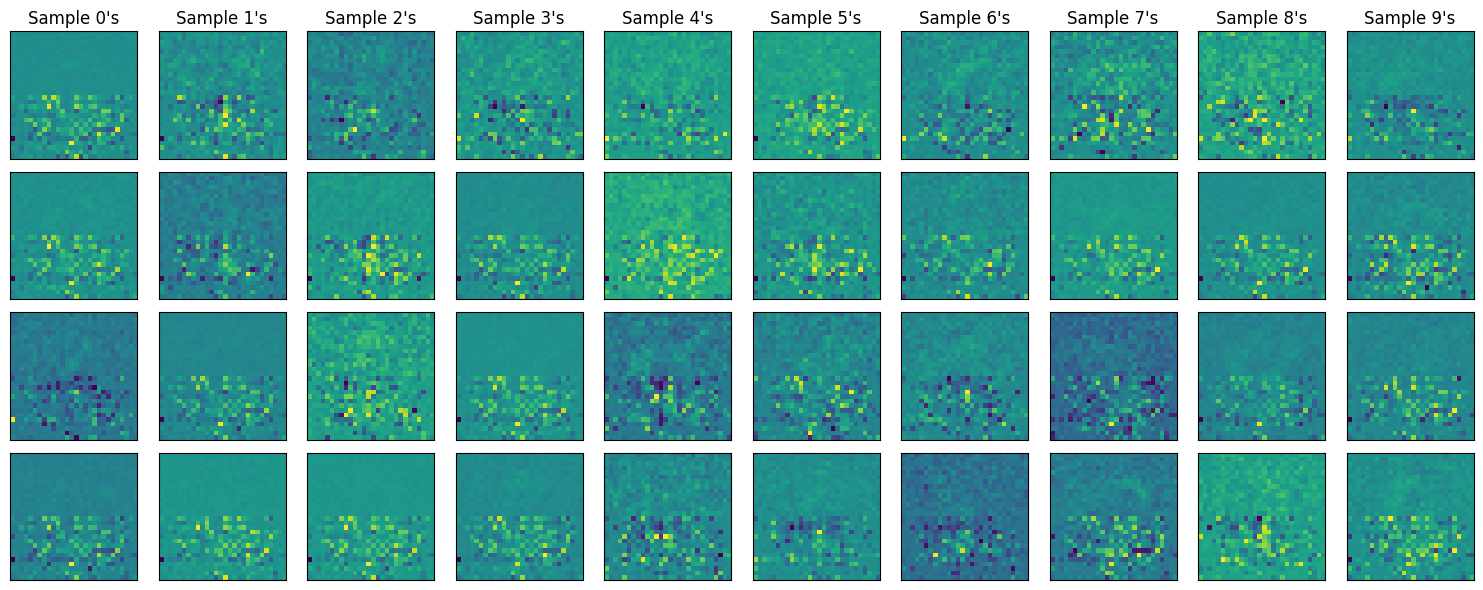

In [23]:
fig, ax = plt.subplots(nrows, ncols, figsize=(plotsize * ncols, plotsize * nrows))

for j in range(ncols):
    ax[0, j].set_title(f"Sample {j}'s")
    for i in range(nrows):
        _ax = ax[i, j]
        _ax.imshow(X_hat[i, j])
        _ax.set_xticks([])
        _ax.set_yticks([])

plt.tight_layout()
plt.show()

## Trace sample through model

In [31]:
Z = torch.randn((len(y), 9))
trace_Z = [Z]
layer_names = ["Noise"]

with torch.no_grad():
    for layer in reversed(sv_maxpool.layers):
        Z = layer.backward(Z, y)
        trace_Z.append(Z)
        layer_names.append(type(layer))

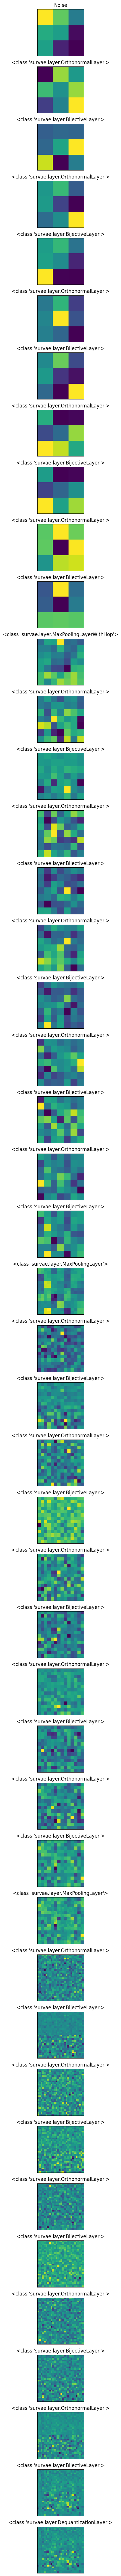

In [35]:
fig, ax = plt.subplots(len(trace_Z), 1, figsize=(2, 2 * len(trace_Z)))

for i, _Z in enumerate(trace_Z):
    _ax = ax[i]
    width = int(np.sqrt(_Z.shape[-1]))
    _ax.imshow(_Z[0].reshape(width, width).cpu().numpy())

    _ax.set_title(layer_names[i])
    _ax.set_xticks([])
    _ax.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
orthos = []

for layer in reversed(sv_maxpool.layers):
    if isinstance(layer, OrthonormalLayer):
        orthos.append(layer.o)

## Check that it outputs data in the correct interval

In [ ]:
X_hat[..., 14:, :].shape

In [27]:
X_hist, bins = np.histogram(X_hat.flatten(), bins=50, density=True)

In [28]:
bins_centered = (bins[1:] + bins[:-1]) / 2
bin_width = bins[1] - bins[0]

x_05, x_95 = X_hat.quantile(torch.tensor([0.005, 0.995]).cpu())

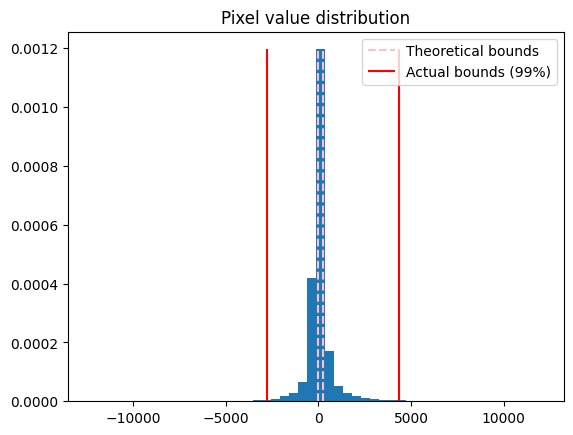

In [29]:
plt.bar(bins_centered, X_hist, bin_width)
plt.vlines([0, 255], 0, X_hist.max(), color='pink', linestyles='--', label='Theoretical bounds')
plt.vlines([x_05, x_95], 0, X_hist.max(), color='red', label='Actual bounds (99%)')

plt.legend()
plt.title("Pixel value distribution")
plt.show()